In [57]:
import uproot
import awkward as ak
import vector 
import pyarrow as pa
import urllib.request
import numpy.ma as ma
import time 
import math 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator,AutoMinorLocator 
from lmfit.models import PolynomialModel, GaussianModel 

import infofile 


In [112]:
#The luminosity of the data
#Make lumni = 0.5 # for data_A only
#Make lumi = 1.9 # fb-1  data_B only
#Make lumi = 2.9 # fb-1 for data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D


                                                                                                                                  
tuple_path = "~/docker/tutorials/4lep/" # local 
#tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

samples = {

    'data': {'list' : ['data_A','data_B','data_C','data_D'],},

    r'Background $Z,t\bar{t}$' : { 'list' : ['Zee','Zmumu','ttbar_lep'],'color' : "#5d4fff" }, # Z + ttbar

    r'Background $ZZ^*$' : {'list' : ['llll'],'color' : "#b54fff" }, # ZZ

    r'Signal ($m_H$ = 125 GeV)' : {'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],'color' : "#ffb495" }, # H -> ZZ -> llll

}

MeV = 0.001
GeV = 1.0

In [94]:
def get_data_from_files():

    data = {} # define empty dictionary to hold awkward arrays
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays

In [52]:
def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON 
        * events.scaleFactor_LepTRIGGER
    )
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV

def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0

def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# cut when none of eeee, mumumumu, eemumu
    num_lep = ak.count(lep_type)
    sum_lep_type = np.sum(lep_type[:, :num_lep], axis =1)
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

^ Want to add more cuts over the summer

In [97]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    data_all = []
    

    with uproot.open(path + ":mini") as tree:
        numevents = tree.num_entrie
        if 'data' not in sample: xsec_weight = get_xsec_weight(sample)
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                                  'lep_E','lep_charge','lep_type', 
                                  'lep_etcone20','lep_ptcone30',
                                  # add more variables here
                                  'mcWeight','scaleFactor_PILEUP',
                                  'scaleFactor_ELE','scaleFactor_MUON',
                                  'scaleFactor_LepTRIGGER'],#These variables needed to calculate the weight
                                 library="ak",
                                 entry_stop=numevents*fraction): 

            nIn = len(data) 

            if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
                data['totalWeight'] = calc_weight(xsec_weight, data)

            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)


            nOut = len(data)
            data_all.append(data) 
            elapsed = time.time() - start 
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) 

You can add more variables above if you want to make graphs of them!

In [98]:
start = time.time() 
data = get_data_from_files() 
elapsed = time.time() - start 
print("Time taken: "+str(round(elapsed,1))+"s")

Processing data samples
	Processing: data_A
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	1	 in 0.5s
		 nIn: 1,	 nOut: 	1	 in 0.5s
		 nIn: 1,	 nOut: 	0	 in 0.6s
		 nIn: 1,	 nOut: 	1	 in 0.7s
		 nIn: 1,	 nOut: 	1	 in 0.8s
		 nIn: 1,	 nOut: 	0	 in 0.8s
		 nIn: 1,	 nOut: 	1	 in 0.9s
		 nIn: 1,	 nOut: 	1	 in 1.0s
		 nIn: 1,	 nOut: 	1	 in 1.0s
		 nIn: 1,	 nOut: 	0	 in 1.1s
		 nIn: 1,	 nOut: 	0	 in 1.2s
		 nIn: 1,	 nOut: 	0	 in 1.2s
		 nIn: 1,	 nOut: 	0	 in 1.3s
		 nIn: 1,	 nOut: 	1	 in 1.4s
		 nIn: 1,	 nOut: 	1	 in 1.4s
		 nIn: 1,	 nOut: 	1	 in 1.5s
		 nIn: 1,	 nOut: 	1	 in 1.6s
		 nIn: 1,	 nOut: 	1	 in 1.6s
		 nIn: 1,	 nOut: 	1	 in 1.7s
		 nIn: 1,	 nOut: 	1	 in 1.8s
		 nIn: 1,	 nOut: 	1	 in 1.9s
		 nIn: 1,	 nOut: 	1	 in 1.9s
		 nIn: 1,	 nOut: 	1	 in 2.0s
		 nIn: 1,	 nOut: 	1	 in 2.1s
		 nIn: 1,	 nOut: 	1	 in 2.1s
		 nIn: 1,	 nOut: 	0	 in 2.2s
		 nIn: 1,	 nOut: 	1	 in 2.3s
		 nIn: 1,	 nOut: 	0	 in 2.4s
		 nIn: 1,	 nOut: 	1	 in 2.4s
		 nIn: 1,	 nOut: 	1	 in 2.5s
		 nIn: 1,	 nOut: 	0	 in 2

		 nIn: 1,	 nOut: 	1	 in 6.3s
		 nIn: 1,	 nOut: 	0	 in 6.4s
		 nIn: 1,	 nOut: 	1	 in 6.5s
		 nIn: 1,	 nOut: 	1	 in 6.5s
		 nIn: 1,	 nOut: 	1	 in 6.6s
		 nIn: 1,	 nOut: 	1	 in 6.7s
		 nIn: 1,	 nOut: 	0	 in 6.8s
		 nIn: 1,	 nOut: 	0	 in 6.8s
		 nIn: 1,	 nOut: 	0	 in 6.9s
		 nIn: 1,	 nOut: 	1	 in 7.0s
		 nIn: 1,	 nOut: 	1	 in 7.1s
		 nIn: 1,	 nOut: 	1	 in 7.2s
		 nIn: 1,	 nOut: 	0	 in 7.2s
		 nIn: 1,	 nOut: 	1	 in 7.3s
		 nIn: 1,	 nOut: 	0	 in 7.4s
		 nIn: 1,	 nOut: 	0	 in 7.5s
		 nIn: 1,	 nOut: 	1	 in 7.6s
		 nIn: 1,	 nOut: 	0	 in 7.6s
		 nIn: 1,	 nOut: 	1	 in 7.7s
		 nIn: 1,	 nOut: 	1	 in 7.8s
		 nIn: 1,	 nOut: 	1	 in 7.9s
		 nIn: 1,	 nOut: 	0	 in 7.9s
		 nIn: 1,	 nOut: 	0	 in 8.0s
		 nIn: 1,	 nOut: 	0	 in 8.1s
		 nIn: 1,	 nOut: 	1	 in 8.2s
		 nIn: 1,	 nOut: 	0	 in 8.2s
		 nIn: 1,	 nOut: 	1	 in 8.3s
		 nIn: 1,	 nOut: 	0	 in 8.4s
		 nIn: 1,	 nOut: 	0	 in 8.5s
		 nIn: 1,	 nOut: 	0	 in 8.5s
		 nIn: 1,	 nOut: 	0	 in 8.6s
		 nIn: 1,	 nOut: 	1	 in 8.7s
		 nIn: 1,	 nOut: 	0	 in 8.7s
		 nIn: 1,

		 nIn: 1,	 nOut: 	0	 in 8.6s
		 nIn: 1,	 nOut: 	1	 in 8.7s
		 nIn: 1,	 nOut: 	1	 in 8.7s
		 nIn: 1,	 nOut: 	1	 in 8.8s
		 nIn: 1,	 nOut: 	1	 in 8.9s
		 nIn: 1,	 nOut: 	0	 in 9.0s
		 nIn: 1,	 nOut: 	1	 in 9.1s
		 nIn: 1,	 nOut: 	0	 in 9.1s
		 nIn: 1,	 nOut: 	1	 in 9.2s
		 nIn: 1,	 nOut: 	0	 in 9.3s
		 nIn: 1,	 nOut: 	0	 in 9.4s
		 nIn: 1,	 nOut: 	1	 in 9.4s
		 nIn: 1,	 nOut: 	1	 in 9.5s
		 nIn: 1,	 nOut: 	1	 in 9.6s
		 nIn: 1,	 nOut: 	0	 in 9.7s
		 nIn: 1,	 nOut: 	1	 in 9.8s
		 nIn: 1,	 nOut: 	1	 in 9.8s
		 nIn: 1,	 nOut: 	0	 in 9.9s
		 nIn: 1,	 nOut: 	1	 in 10.0s
		 nIn: 1,	 nOut: 	1	 in 10.1s
		 nIn: 1,	 nOut: 	0	 in 10.2s
		 nIn: 1,	 nOut: 	0	 in 10.2s
		 nIn: 1,	 nOut: 	1	 in 10.3s
		 nIn: 1,	 nOut: 	1	 in 10.4s
		 nIn: 1,	 nOut: 	1	 in 10.4s
		 nIn: 1,	 nOut: 	1	 in 10.5s
		 nIn: 1,	 nOut: 	1	 in 10.6s
		 nIn: 1,	 nOut: 	1	 in 10.6s
		 nIn: 1,	 nOut: 	0	 in 10.7s
		 nIn: 1,	 nOut: 	1	 in 10.8s
		 nIn: 1,	 nOut: 	1	 in 10.8s
		 nIn: 1,	 nOut: 	1	 in 10.9s
		 nIn: 1,	 nOut: 	0	 in 1

		 nIn: 1,	 nOut: 	1	 in 29.6s
		 nIn: 1,	 nOut: 	1	 in 29.7s
		 nIn: 1,	 nOut: 	0	 in 29.8s
		 nIn: 1,	 nOut: 	0	 in 29.8s
		 nIn: 1,	 nOut: 	1	 in 29.9s
		 nIn: 1,	 nOut: 	1	 in 30.0s
		 nIn: 1,	 nOut: 	1	 in 30.1s
		 nIn: 1,	 nOut: 	0	 in 30.2s
		 nIn: 1,	 nOut: 	1	 in 30.2s
		 nIn: 1,	 nOut: 	0	 in 30.3s
		 nIn: 1,	 nOut: 	1	 in 30.4s
		 nIn: 1,	 nOut: 	0	 in 30.5s
		 nIn: 1,	 nOut: 	1	 in 30.5s
		 nIn: 1,	 nOut: 	1	 in 30.6s
		 nIn: 1,	 nOut: 	0	 in 30.7s
		 nIn: 1,	 nOut: 	0	 in 30.8s
		 nIn: 1,	 nOut: 	0	 in 30.8s
		 nIn: 1,	 nOut: 	0	 in 30.9s
		 nIn: 1,	 nOut: 	1	 in 31.0s
		 nIn: 1,	 nOut: 	1	 in 31.1s
		 nIn: 1,	 nOut: 	1	 in 31.1s
		 nIn: 1,	 nOut: 	0	 in 31.2s
		 nIn: 1,	 nOut: 	1	 in 31.4s
		 nIn: 1,	 nOut: 	0	 in 31.4s
Processing Background $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 1,	 nOut: 	0	 in 0.2s
		 nIn: 1,	 nOut: 	0	 in 0.2s
		 nIn: 1,	 nOut: 	0	 in 0.3s
		 nIn: 1,	 nOut: 	1	 in 0.4s
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	0	 in 0.5s
		 nIn: 1,	 nOut

		 nIn: 1,	 nOut: 	0	 in 19.1s
		 nIn: 1,	 nOut: 	0	 in 19.2s
		 nIn: 1,	 nOut: 	0	 in 19.3s
		 nIn: 1,	 nOut: 	0	 in 19.3s
		 nIn: 1,	 nOut: 	0	 in 19.4s
		 nIn: 1,	 nOut: 	0	 in 19.5s
		 nIn: 1,	 nOut: 	0	 in 19.5s
		 nIn: 1,	 nOut: 	1	 in 19.6s
		 nIn: 1,	 nOut: 	0	 in 19.7s
		 nIn: 1,	 nOut: 	1	 in 19.7s
		 nIn: 1,	 nOut: 	0	 in 19.8s
		 nIn: 1,	 nOut: 	0	 in 19.9s
		 nIn: 1,	 nOut: 	0	 in 19.9s
		 nIn: 1,	 nOut: 	0	 in 20.0s
		 nIn: 1,	 nOut: 	0	 in 20.1s
		 nIn: 1,	 nOut: 	0	 in 20.1s
		 nIn: 1,	 nOut: 	0	 in 20.2s
		 nIn: 1,	 nOut: 	0	 in 20.3s
		 nIn: 1,	 nOut: 	0	 in 20.3s
		 nIn: 1,	 nOut: 	0	 in 20.4s
		 nIn: 1,	 nOut: 	0	 in 20.5s
		 nIn: 1,	 nOut: 	0	 in 20.6s
		 nIn: 1,	 nOut: 	0	 in 20.6s
		 nIn: 1,	 nOut: 	0	 in 20.7s
		 nIn: 1,	 nOut: 	0	 in 20.8s
		 nIn: 1,	 nOut: 	0	 in 20.8s
		 nIn: 1,	 nOut: 	1	 in 20.9s
		 nIn: 1,	 nOut: 	0	 in 21.0s
		 nIn: 1,	 nOut: 	0	 in 21.0s
		 nIn: 1,	 nOut: 	0	 in 21.1s
		 nIn: 1,	 nOut: 	0	 in 21.2s
		 nIn: 1,	 nOut: 	1	 in 21.2s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 37.6s
		 nIn: 1,	 nOut: 	0	 in 37.7s
		 nIn: 1,	 nOut: 	1	 in 37.7s
		 nIn: 1,	 nOut: 	0	 in 37.8s
		 nIn: 1,	 nOut: 	0	 in 37.9s
		 nIn: 1,	 nOut: 	0	 in 38.0s
		 nIn: 1,	 nOut: 	1	 in 38.0s
		 nIn: 1,	 nOut: 	0	 in 38.1s
		 nIn: 1,	 nOut: 	1	 in 38.2s
		 nIn: 1,	 nOut: 	1	 in 38.2s
		 nIn: 1,	 nOut: 	1	 in 38.3s
		 nIn: 1,	 nOut: 	0	 in 38.4s
		 nIn: 1,	 nOut: 	0	 in 38.4s
		 nIn: 1,	 nOut: 	0	 in 38.5s
		 nIn: 1,	 nOut: 	1	 in 38.6s
		 nIn: 1,	 nOut: 	0	 in 38.7s
		 nIn: 1,	 nOut: 	1	 in 38.7s
		 nIn: 1,	 nOut: 	0	 in 38.8s
		 nIn: 1,	 nOut: 	1	 in 38.9s
		 nIn: 1,	 nOut: 	1	 in 38.9s
		 nIn: 1,	 nOut: 	0	 in 39.0s
		 nIn: 1,	 nOut: 	0	 in 39.1s
		 nIn: 1,	 nOut: 	0	 in 39.1s
		 nIn: 1,	 nOut: 	0	 in 39.2s
		 nIn: 1,	 nOut: 	0	 in 39.3s
		 nIn: 1,	 nOut: 	1	 in 39.3s
		 nIn: 1,	 nOut: 	0	 in 39.4s
		 nIn: 1,	 nOut: 	0	 in 39.5s
		 nIn: 1,	 nOut: 	1	 in 39.5s
		 nIn: 1,	 nOut: 	0	 in 39.6s
		 nIn: 1,	 nOut: 	0	 in 39.7s
		 nIn: 1,	 nOut: 	0	 in 39.7s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 57.1s
		 nIn: 1,	 nOut: 	0	 in 57.1s
		 nIn: 1,	 nOut: 	0	 in 57.2s
		 nIn: 1,	 nOut: 	0	 in 57.3s
		 nIn: 1,	 nOut: 	0	 in 57.3s
		 nIn: 1,	 nOut: 	0	 in 57.4s
		 nIn: 1,	 nOut: 	1	 in 57.5s
		 nIn: 1,	 nOut: 	0	 in 57.5s
		 nIn: 1,	 nOut: 	0	 in 57.6s
		 nIn: 1,	 nOut: 	1	 in 57.7s
		 nIn: 1,	 nOut: 	0	 in 57.7s
		 nIn: 1,	 nOut: 	0	 in 57.8s
		 nIn: 1,	 nOut: 	0	 in 57.9s
		 nIn: 1,	 nOut: 	1	 in 58.0s
		 nIn: 1,	 nOut: 	0	 in 58.0s
		 nIn: 1,	 nOut: 	0	 in 58.1s
		 nIn: 1,	 nOut: 	0	 in 58.2s
		 nIn: 1,	 nOut: 	0	 in 58.2s
		 nIn: 1,	 nOut: 	0	 in 58.3s
		 nIn: 1,	 nOut: 	0	 in 58.4s
		 nIn: 1,	 nOut: 	0	 in 58.4s
		 nIn: 1,	 nOut: 	1	 in 58.5s
		 nIn: 1,	 nOut: 	1	 in 58.6s
		 nIn: 1,	 nOut: 	0	 in 58.6s
		 nIn: 1,	 nOut: 	0	 in 58.7s
		 nIn: 1,	 nOut: 	0	 in 58.8s
		 nIn: 1,	 nOut: 	0	 in 58.8s
		 nIn: 1,	 nOut: 	1	 in 58.9s
		 nIn: 1,	 nOut: 	0	 in 59.0s
		 nIn: 1,	 nOut: 	1	 in 59.0s
		 nIn: 1,	 nOut: 	1	 in 59.1s
		 nIn: 1,	 nOut: 	0	 in 59.2s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 11.3s
		 nIn: 1,	 nOut: 	0	 in 11.4s
		 nIn: 1,	 nOut: 	0	 in 11.4s
		 nIn: 1,	 nOut: 	0	 in 11.5s
		 nIn: 1,	 nOut: 	0	 in 11.6s
		 nIn: 1,	 nOut: 	1	 in 11.7s
		 nIn: 1,	 nOut: 	0	 in 11.7s
		 nIn: 1,	 nOut: 	0	 in 11.8s
		 nIn: 1,	 nOut: 	1	 in 11.8s
		 nIn: 1,	 nOut: 	0	 in 11.9s
		 nIn: 1,	 nOut: 	1	 in 12.0s
		 nIn: 1,	 nOut: 	0	 in 12.0s
		 nIn: 1,	 nOut: 	0	 in 12.1s
		 nIn: 1,	 nOut: 	1	 in 12.2s
		 nIn: 1,	 nOut: 	0	 in 12.2s
		 nIn: 1,	 nOut: 	1	 in 12.3s
		 nIn: 1,	 nOut: 	0	 in 12.4s
		 nIn: 1,	 nOut: 	0	 in 12.5s
		 nIn: 1,	 nOut: 	1	 in 12.5s
		 nIn: 1,	 nOut: 	0	 in 12.6s
		 nIn: 1,	 nOut: 	0	 in 12.7s
		 nIn: 1,	 nOut: 	1	 in 12.7s
		 nIn: 1,	 nOut: 	1	 in 12.8s
		 nIn: 1,	 nOut: 	0	 in 12.9s
		 nIn: 1,	 nOut: 	0	 in 12.9s
		 nIn: 1,	 nOut: 	1	 in 13.0s
		 nIn: 1,	 nOut: 	0	 in 13.1s
		 nIn: 1,	 nOut: 	0	 in 13.1s
		 nIn: 1,	 nOut: 	0	 in 13.2s
		 nIn: 1,	 nOut: 	0	 in 13.3s
		 nIn: 1,	 nOut: 	1	 in 13.3s
		 nIn: 1,	 nOut: 	1	 in 13.4s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 30.0s
		 nIn: 1,	 nOut: 	1	 in 30.1s
		 nIn: 1,	 nOut: 	1	 in 30.2s
		 nIn: 1,	 nOut: 	0	 in 30.2s
		 nIn: 1,	 nOut: 	1	 in 30.3s
		 nIn: 1,	 nOut: 	1	 in 30.4s
		 nIn: 1,	 nOut: 	0	 in 30.5s
		 nIn: 1,	 nOut: 	0	 in 30.5s
		 nIn: 1,	 nOut: 	0	 in 30.6s
		 nIn: 1,	 nOut: 	0	 in 30.7s
		 nIn: 1,	 nOut: 	1	 in 30.8s
		 nIn: 1,	 nOut: 	0	 in 30.8s
		 nIn: 1,	 nOut: 	0	 in 30.9s
		 nIn: 1,	 nOut: 	0	 in 30.9s
		 nIn: 1,	 nOut: 	0	 in 31.0s
		 nIn: 1,	 nOut: 	0	 in 31.1s
		 nIn: 1,	 nOut: 	1	 in 31.2s
		 nIn: 1,	 nOut: 	1	 in 31.2s
		 nIn: 1,	 nOut: 	0	 in 31.3s
		 nIn: 1,	 nOut: 	0	 in 31.4s
		 nIn: 1,	 nOut: 	0	 in 31.4s
		 nIn: 1,	 nOut: 	1	 in 31.5s
		 nIn: 1,	 nOut: 	0	 in 31.6s
		 nIn: 1,	 nOut: 	1	 in 31.6s
		 nIn: 1,	 nOut: 	0	 in 31.7s
		 nIn: 1,	 nOut: 	0	 in 31.8s
		 nIn: 1,	 nOut: 	0	 in 31.8s
		 nIn: 1,	 nOut: 	0	 in 31.9s
		 nIn: 1,	 nOut: 	0	 in 32.0s
		 nIn: 1,	 nOut: 	0	 in 32.0s
		 nIn: 1,	 nOut: 	0	 in 32.1s
		 nIn: 1,	 nOut: 	1	 in 32.2s
		 nIn: 

	Processing: ttbar_lep
		 nIn: 1,	 nOut: 	0	 in 0.1s
		 nIn: 1,	 nOut: 	0	 in 0.2s
		 nIn: 1,	 nOut: 	0	 in 0.3s
		 nIn: 1,	 nOut: 	0	 in 0.3s
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	0	 in 0.5s
		 nIn: 1,	 nOut: 	0	 in 0.5s
		 nIn: 1,	 nOut: 	1	 in 0.6s
		 nIn: 1,	 nOut: 	1	 in 0.7s
		 nIn: 1,	 nOut: 	0	 in 0.7s
		 nIn: 1,	 nOut: 	0	 in 0.8s
		 nIn: 1,	 nOut: 	0	 in 0.9s
		 nIn: 1,	 nOut: 	1	 in 0.9s
		 nIn: 1,	 nOut: 	1	 in 1.0s
		 nIn: 1,	 nOut: 	1	 in 1.1s
		 nIn: 1,	 nOut: 	1	 in 1.2s
		 nIn: 1,	 nOut: 	0	 in 1.3s
		 nIn: 1,	 nOut: 	1	 in 1.3s
		 nIn: 1,	 nOut: 	0	 in 1.4s
		 nIn: 1,	 nOut: 	0	 in 1.5s
		 nIn: 1,	 nOut: 	0	 in 1.6s
		 nIn: 1,	 nOut: 	0	 in 1.6s
		 nIn: 1,	 nOut: 	0	 in 1.8s
		 nIn: 1,	 nOut: 	0	 in 1.9s
		 nIn: 1,	 nOut: 	0	 in 1.9s
		 nIn: 1,	 nOut: 	0	 in 2.0s
		 nIn: 1,	 nOut: 	0	 in 2.1s
		 nIn: 1,	 nOut: 	1	 in 2.2s
		 nIn: 1,	 nOut: 	0	 in 2.2s
		 nIn: 1,	 nOut: 	1	 in 2.3s
		 nIn: 1,	 nOut: 	1	 in 2.4s
		 nIn: 1,	 nOut: 	0	 in 2.5s
		 nIn: 1,	 nOut:

		 nIn: 1,	 nOut: 	0	 in 19.2s
		 nIn: 1,	 nOut: 	0	 in 19.3s
		 nIn: 1,	 nOut: 	1	 in 19.4s
		 nIn: 1,	 nOut: 	0	 in 19.6s
		 nIn: 1,	 nOut: 	0	 in 19.6s
		 nIn: 1,	 nOut: 	0	 in 19.7s
		 nIn: 1,	 nOut: 	0	 in 19.8s
		 nIn: 1,	 nOut: 	0	 in 19.9s
		 nIn: 1,	 nOut: 	0	 in 20.0s
		 nIn: 1,	 nOut: 	0	 in 20.0s
		 nIn: 1,	 nOut: 	0	 in 20.1s
		 nIn: 1,	 nOut: 	0	 in 20.2s
		 nIn: 1,	 nOut: 	0	 in 20.2s
		 nIn: 1,	 nOut: 	0	 in 20.3s
		 nIn: 1,	 nOut: 	0	 in 20.4s
		 nIn: 1,	 nOut: 	0	 in 20.4s
		 nIn: 1,	 nOut: 	0	 in 20.5s
		 nIn: 1,	 nOut: 	1	 in 20.6s
		 nIn: 1,	 nOut: 	0	 in 20.6s
		 nIn: 1,	 nOut: 	0	 in 20.7s
		 nIn: 1,	 nOut: 	1	 in 20.8s
		 nIn: 1,	 nOut: 	0	 in 20.8s
		 nIn: 1,	 nOut: 	0	 in 20.9s
		 nIn: 1,	 nOut: 	1	 in 21.0s
		 nIn: 1,	 nOut: 	1	 in 21.1s
		 nIn: 1,	 nOut: 	0	 in 21.2s
		 nIn: 1,	 nOut: 	1	 in 21.2s
		 nIn: 1,	 nOut: 	1	 in 21.3s
		 nIn: 1,	 nOut: 	0	 in 21.4s
		 nIn: 1,	 nOut: 	0	 in 21.5s
		 nIn: 1,	 nOut: 	1	 in 21.6s
		 nIn: 1,	 nOut: 	0	 in 21.6s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 38.8s
		 nIn: 1,	 nOut: 	0	 in 38.8s
		 nIn: 1,	 nOut: 	0	 in 38.9s
		 nIn: 1,	 nOut: 	0	 in 39.0s
		 nIn: 1,	 nOut: 	0	 in 39.0s
		 nIn: 1,	 nOut: 	1	 in 39.1s
		 nIn: 1,	 nOut: 	1	 in 39.2s
		 nIn: 1,	 nOut: 	0	 in 39.2s
		 nIn: 1,	 nOut: 	1	 in 39.3s
		 nIn: 1,	 nOut: 	1	 in 39.4s
		 nIn: 1,	 nOut: 	0	 in 39.4s
		 nIn: 1,	 nOut: 	0	 in 39.5s
		 nIn: 1,	 nOut: 	0	 in 39.6s
		 nIn: 1,	 nOut: 	0	 in 39.7s
		 nIn: 1,	 nOut: 	1	 in 39.7s
		 nIn: 1,	 nOut: 	0	 in 39.8s
		 nIn: 1,	 nOut: 	0	 in 39.9s
		 nIn: 1,	 nOut: 	1	 in 39.9s
		 nIn: 1,	 nOut: 	0	 in 40.0s
		 nIn: 1,	 nOut: 	0	 in 40.1s
		 nIn: 1,	 nOut: 	0	 in 40.1s
		 nIn: 1,	 nOut: 	1	 in 40.2s
		 nIn: 1,	 nOut: 	0	 in 40.3s
		 nIn: 1,	 nOut: 	0	 in 40.3s
		 nIn: 1,	 nOut: 	1	 in 40.4s
		 nIn: 1,	 nOut: 	1	 in 40.5s
		 nIn: 1,	 nOut: 	1	 in 40.5s
		 nIn: 1,	 nOut: 	1	 in 40.6s
		 nIn: 1,	 nOut: 	0	 in 40.7s
		 nIn: 1,	 nOut: 	1	 in 40.7s
		 nIn: 1,	 nOut: 	1	 in 40.8s
		 nIn: 1,	 nOut: 	1	 in 40.9s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 57.6s
		 nIn: 1,	 nOut: 	1	 in 57.7s
		 nIn: 1,	 nOut: 	0	 in 57.8s
		 nIn: 1,	 nOut: 	1	 in 57.8s
		 nIn: 1,	 nOut: 	1	 in 57.9s
		 nIn: 1,	 nOut: 	0	 in 58.0s
		 nIn: 1,	 nOut: 	0	 in 58.0s
		 nIn: 1,	 nOut: 	0	 in 58.1s
		 nIn: 1,	 nOut: 	1	 in 58.2s
		 nIn: 1,	 nOut: 	0	 in 58.2s
		 nIn: 1,	 nOut: 	0	 in 58.3s
		 nIn: 1,	 nOut: 	1	 in 58.4s
		 nIn: 1,	 nOut: 	0	 in 58.4s
		 nIn: 1,	 nOut: 	0	 in 58.5s
		 nIn: 1,	 nOut: 	1	 in 58.6s
		 nIn: 1,	 nOut: 	1	 in 58.6s
		 nIn: 1,	 nOut: 	1	 in 58.7s
		 nIn: 1,	 nOut: 	1	 in 58.8s
		 nIn: 1,	 nOut: 	0	 in 58.8s
		 nIn: 1,	 nOut: 	1	 in 58.9s
		 nIn: 1,	 nOut: 	0	 in 59.0s
		 nIn: 1,	 nOut: 	0	 in 59.0s
		 nIn: 1,	 nOut: 	0	 in 59.1s
		 nIn: 1,	 nOut: 	0	 in 59.2s
		 nIn: 1,	 nOut: 	0	 in 59.3s
		 nIn: 1,	 nOut: 	0	 in 59.3s
		 nIn: 1,	 nOut: 	0	 in 59.4s
		 nIn: 1,	 nOut: 	1	 in 59.5s
		 nIn: 1,	 nOut: 	0	 in 59.6s
		 nIn: 1,	 nOut: 	0	 in 59.6s
		 nIn: 1,	 nOut: 	0	 in 59.7s
		 nIn: 1,	 nOut: 	0	 in 59.8s
		 nIn: 

In [100]:
start = time.time()
df = ak.to_dataframe(data)
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Time taken: 796.3s


In [102]:
df

data                                                \
                       lep_pt   lep_eta   lep_phi          lep_E lep_charge   
entry subentry                                                                
0     0         175558.734375  2.076854  1.292963  711421.062500         -1   
      1         138846.671875  0.964199 -2.256139  208545.921875          1   
      2         106696.531250  0.453812 -1.797010  117873.273438         -1   
      3          79776.726562  2.398578  0.587067  442695.562500          1   
1     0          65284.066406  0.103152  2.329535   65631.695312         -1   
...                       ...       ...       ...            ...        ...   
504   3          26180.353516  1.285183 -1.999637   50946.031250         -1   
505   0          88545.625000 -0.845567 -0.930286  122131.515625          1   
      1          50751.835938  0.115409  1.808202   51090.308594          1   
      2          25529.919922  2.211767  0.654854  117965.445312         -1   
      3          22951.449219 -0.205597  1.450882   23438.242188         -1   

                                                                               \
               lep_type lep_etcone20 lep_ptcone30 mcWeight scaleFactor_PILEUP   
entry subentry                                                                  
0     0              11  2027.695679          0.0      0.0                0.0   
      1              13  -366.941406          0.0      0.0                0.0   
      2              13  -366.941406          0.0      0.0                0.0   
      3              11  2243.681641          0.0      0.0                0.0   
1     0              11   306.743713          0.0      0.0                0.0   
...                 ...          ...          ...      ...                ...   
504   3              11   -19.025299          0.0      0.0                0.0   
505   0              11  3321.877930          0.0      0.0                0.0   
      1              13  -131.771484          0.0      0.0                0.0   
      2              13  -365.461212          0.0      0.0                0.0   
      3              11  -267.957947          0.0      0.0                0.0   

                ... Signal ($m_H$ = 125 GeV)                            \
                ...                 lep_type lep_etcone20 lep_ptcone30   
entry subentry  ...                                                      
0     0         ...                       13  -265.445374     0.000000   
      1         ...                       13  1418.375000     0.000000   
      2         ...                       13  1168.589355     0.000000   
      3         ...                       13  -865.490173     0.000000   
1     0         ...                       13 -1258.264771  1024.780762   
...             ...                      ...          ...          ...   
504   3         ...                       13  -520.922913     0.000000   
505   0         ...                       11   782.970276     0.000000   
      1         ...                       11  -225.391449     0.000000   
      2         ...                       13  1154.791992  2338.773193   
      3         ...                       13  -502.700684     0.000000   

                                                                               \
                 mcWeight scaleFactor_PILEUP scaleFactor_ELE scaleFactor_MUON   
entry subentry                                                                  
0     0         28.485731           0.351687        1.000000         0.984327   
      1         28.485731           0.351687        1.000000         0.984327   
      2         28.485731           0.351687        1.000000         0.984327   
      3         28.485731           0.351687        1.000000         0.984327   
1     0         28.485731           0.553627        1.000000         0.985408   
...                   ...                ...             ...              ...   
504   3         2

In [1]:
def plot_data_variable(variable, mini,maxi, step, unit = ''):# Variable, x axis minimun , x axis maximum and step size
    #And unit. Will add how to automatically do it based on varible
    xmin = mini * GeV
    xmax = maxi
    step_size = step * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(((df['data'][variable]).to_numpy()).flatten(), bins=bin_edges) 
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ((df[r'Signal ($m_H$ = 125 GeV)'][variable]).to_numpy()).flatten() # histogram the signal
    signal_weights = (df[r'Signal ($m_H$ = 125 GeV)']['totalWeight']).to_numpy() # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append(((df[s][variable]).to_numpy()).flatten()) # append to the list of Monte Carlo histogram entries
            mc_weights.append((df[s]['totalWeight']).to_numpy())# append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels

            
    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges,# weights =mc_weights, #[TAKEAWAY # TO APPLY WEIGHTS ~ G]
                                stacked=False, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1]
     # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges,weights = signal_weights, 
                   bottom=mc_x_tot, 
                   color=signal_color)
                   #label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel((variable + unit),
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top= (np.amax(data_x)*1.6))
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False, loc = 'upper right' ) # no box around the legend
    print(mc_x[1])
    return

[154220.28125     91854.9453125   87447.3046875  ...  22604.27734375
  24719.08789062  15847.99023438]


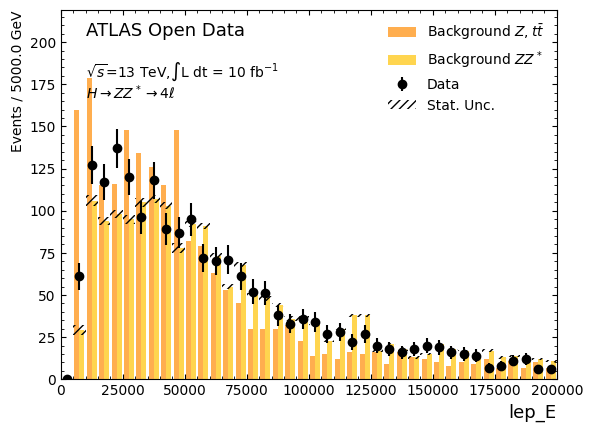

In [96]:
plot_data_variable('lep_E', (0), (200000),(5000))

[ -362.1232605   -124.68487549  -350.91021729 ... -1284.92810059
  -260.05960083  -707.91320801]


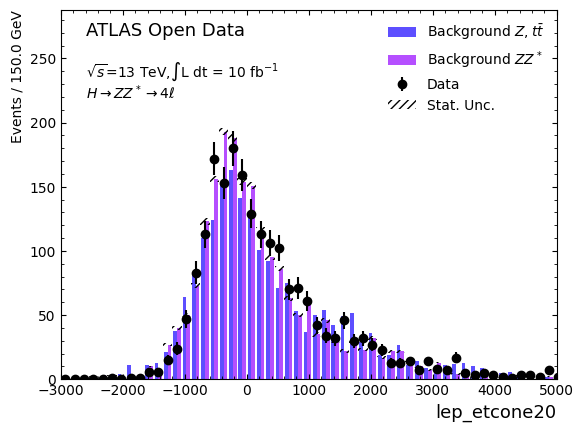

In [114]:
plot_data_variable('lep_etcone20', (-3000), (5000),(150))